In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
import anndata

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [2]:
device = 'cuda'
# device = 'cpu'

In [3]:
%load_ext autoreload
%autoreload 2

## define helper functions

In [4]:
# define a function to gather positions
def get_pos(n_x, n_y):
    # create the hex lattice
    xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
    # derive the y-step given a distance of one
    y_step = np.sqrt(1**2+0.5**2)
    ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
    # define the positions
    pos = np.vstack([xs.flatten(), ys.flatten()]).T
    return pos

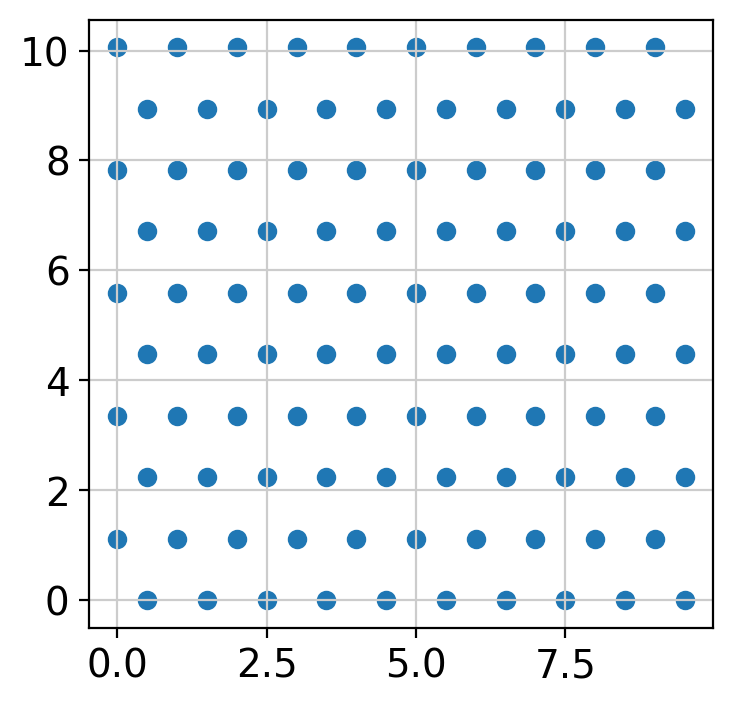

In [5]:
pos = get_pos(10, 10)
plt.scatter( pos[:,0], pos[:,1])

In [6]:
# define a function to derive the gex from the sphex
def calc_gex(sphex):
    """
    Calculates the gene expression matrix from the spherical
    """
    # setup the gex
    n_genes = sphex.shape[1]+1
    gex = torch.from_numpy(np.ones((sphex.shape[0], n_genes)).astype('float32')).to(device)
    # compute the gex
    for idx in range(n_genes):
        for idx_ in range(idx):
            gex[:,idx] *= torch.sin(sphex[:,idx_])
        if idx < n_genes-1:
            gex[:,idx] *= torch.cos(sphex[:,idx])
    return torch.nan_to_num(gex).to(device)

In [7]:
from torch_geometric.nn import GCNConv
from sklearn.neighbors import kneighbors_graph
# define the number of neighbors (six for visium)
n_neighbors = 6
# define the simcomen class
class simcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(simcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.sphex = None
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_sphex(self, sphex):
        """
        Artifically sets the current sphex matrix
        """
        self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the gex
        self.gex = calc_gex(self.sphex)
        edge_index = edge_index.to(device)
        
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [8]:
# define the celcomen class
class celcomen(torch.nn.Module):
    # define initialization function
    def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
        super(celcomen, self).__init__()
        # define the seed
        torch.manual_seed(seed)
        # set up the graph convolution
        self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
        # set up the linear layer for intracellular gene regulation
        self.lin = torch.nn.Linear(input_dim, output_dim)
        # define the neighbors
        self.n_neighbors = n_neighbors
        # define a tracking variable for the gene expression x matrix
        self.gex = None

    # define a function to artificially set the g2g matrix
    def set_g2g(self, g2g):
        """
        Artifically sets the core g2g matrix to be a specified interaction matrix
        """
        # set the weight as the input
        self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
        # and then set the bias as all zeros
        self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

    # define a function to artificially set the g2g matrix
    def set_g2g_intra(self, g2g_intra):
        """
        Artifically sets the core g2g intracellular matrix to be a specified matrix
        """
        # set the weight as the input
        self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
        # and then set the bias as all zeros
        self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

    # define a function to artificially set the sphex matrix
    def set_gex(self, gex):
        """
        Artifically sets the current sphex matrix
        """
        self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
    # define the forward pass
    def forward(self, edge_index, batch):
        """
        Forward pass for prediction or training,
        convolutes the input by the expected interactions and returns log(Z_mft)
        """
        # compute the message
        msg = self.conv1(self.gex, edge_index)
        # compute intracellular message
        msg_intra = self.lin(self.gex)
        # compute the log z mft
        log_z_mft = self.log_Z_mft(edge_index, batch)
        return msg, msg_intra, log_z_mft

    # define approximation function
    def log_Z_mft(self, edge_index, batch):
        """
        Mean Field Theory approximation to the partition function. Assumptions used are:
        - expression of values of genes are close to their mean values over the visium slide
        - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
          interaction matrix.
        """
        # retrieve number of spots
        num_spots = self.gex.shape[0]
        # calculate mean gene expression        
        mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
        # calculate the norm of the sum of mean genes
        g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
        # calculate the contribution for mean values        
        z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
        # calculate the contribution gene interactions
        z_interaction = self.z_interaction(num_spots=num_spots, g=g)
        # add the two contributions        
        log_z_mft = z_mean + z_interaction
        return log_z_mft

    def z_interaction(self, num_spots, g):
        """
        Avoid exploding exponentials by returning an approximate interaction term for the partition function.
        """
        if g>20:
            z_interaction = num_spots * ( g - torch.log( g) )
        else:
            z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
        return z_interaction

In [9]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## perform simulations

In [10]:
# original: NO jump start


def run_scc(input_g2g, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    # instantiate the model, input and output will be the same
    model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    # artifically set the g2g matrix
    model.set_g2g(input_g2g)
    model.set_g2g_intra(input_g2g)

    # initialize a gene expression matrix
    input_sphex = np.random.normal(np.pi/4, np.pi/8, size=(pos.shape[0], n_genes-1)).astype('float32')
    model.set_sphex(torch.from_numpy(input_sphex.copy()))

    # move to device
    model.to(device)
    # train the model
    model.train()
            
    # set up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []

    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model(edge_index, 1)
        if epoch == 0:
            input_gex, input_msg = model.gex.clone().detach().cpu().numpy(), msg.clone().detach().cpu().numpy()
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')

    spearman_corr, pval = ss.spearmanr( losses, sorted(losses) )
    # print(f"spearman_corr={spearman_corr}")

    # retrieve the data
    output_gex = model.gex.detach().cpu().numpy()
    output_msg = msg.detach().cpu().numpy()
    exp_g2g = input_g2g.detach().cpu().numpy()
    # plot the correlations
    if plot:
        for matrix in [input_gex, input_msg, output_gex, output_msg]:
            g = sns.clustermap(pd.DataFrame(matrix).corr(method='spearman'), cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                               figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
            g.ax_heatmap.grid(False)
            g.ax_cbar.grid(False)
            g.ax_heatmap.tick_params(labelrotation=0)
        # plot the expected g2g matrix
        g = sns.clustermap(exp_g2g, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
        
    return losses, input_gex, output_gex, exp_g2g

In [11]:
def run_ccc_from_scc(output_gex, params, plot=False):
    # define the hyperparameters
    n_x, n_y, n_genes = params[:3]
    learning_rate = params[3]
    zmft_scalar = params[4]
    seed = params[5]
    epochs = params[6]
    
    # retrieve the positions
    pos = torch.from_numpy(get_pos(n_x, n_y).astype('float32'))
    # find the edges via kneighbors, not including self because we are considering intercellular
    edge_index = kneighbors_graph(pos, n_neighbors, include_self=False).todense()
    edge_index = torch.from_numpy(np.array(np.where(edge_index)))
    edge_index = edge_index.to(device)
    
    # instantiate the model, input and output will be the same
    model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
    
    # now perform the simulation
    np.random.seed(seed)
    # artifically set the g2g matrix
    input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
    input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)
    model_rev.set_g2g(torch.from_numpy(input_g2g))
    model_rev.set_g2g_intra(torch.from_numpy(input_g2g))
    # initialize a gene expression matrix
    model_rev.set_gex(torch.from_numpy(output_gex))
    
    # setup the initial optimizer
    optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
    # keep track of the losses per data object
    loss, losses = None, []
    # train the model
    model_rev.train()
    model_rev.to(device)
    
    # work through epochs
    for epoch in range(epochs):
        # derive the message as well as the mean field approximation
        msg, msg_intra, log_z_mft = model_rev(edge_index, 1)
        # compute the loss and track it
        loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_rev.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_rev.gex))) )
        losses.append(loss.detach().cpu().numpy()[0][0])
        # derive the gradients, update, and clear
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # repeatedly force a normalization
        model_rev.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.conv1.lin.weight), requires_grad=True)
        model_rev.lin.weight = torch.nn.Parameter(normalize_g2g(model_rev.lin.weight), requires_grad=True)
        optimizer = torch.optim.SGD(model_rev.parameters(), lr=learning_rate, momentum=0)
        
    # create the plot
    if plot:
        fig, ax = plt.subplots(figsize=[6, 4])
        ax.grid(False)
        ax.plot(losses, lw=2, color='#fe86a4')
        ax.set_xlim(0, epochs)
        vmin, vmax = min(min(losses), 0), max(losses)
        vstep = (vmax - vmin) * 0.01
        ax.set_ylim(vmin-vstep, vmax+vstep)
        ax.set(xlabel='epochs', ylabel='loss')
    
    # retrieve the data
    obs_g2g_ccc = model_rev.conv1.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_ccc, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)
    obs_g2g_intra = model_rev.lin.weight.clone().detach().cpu().numpy()
    if plot:
        g = sns.clustermap(obs_g2g_intra, cmap='seismic', row_cluster=False, col_cluster=False, vmin=-1, vmax=1,
                           figsize=[1+n_genes*0.5, 1+n_genes*0.5], dendrogram_ratio=0.1, cbar_pos=(-0.1, 1, .02, .12))
        g.ax_heatmap.grid(False)
        g.ax_cbar.grid(False)
        g.ax_heatmap.tick_params(labelrotation=0)

    return losses, obs_g2g_ccc, obs_g2g_intra

In [12]:
# define a function to generate a random g2g interaction matrix
def gen_g2g(n_genes):
    # sample the interaction terms and guarantee at least one interaction
    p = ss.uniform.rvs(size=1)[0]
    intrxns = [0]
    # we continously sample until we get interactions that do are not all empty or full
    while (np.mean(intrxns) == 0.0) | (np.mean(intrxns) == 1.0):
        intrxns = ss.binom.rvs(1, p, size=sum(list(range(n_genes))))
    # fill in the input g2g with the appropriate terms
    input_g2g = np.ones((n_genes, n_genes)).astype('float32')
    idz = 0
    for idx in range(n_genes-1):
        for idy in range(idx+1, n_genes):
            input_g2g[idx, idy] = intrxns[idz]
            input_g2g[idy, idx] = intrxns[idz]
            idz += 1
    input_g2g = torch.tensor(input_g2g)
    return input_g2g

In [13]:
def gen_g2g_uni(n_genes):
    # sample the interaction terms and guarantee at least one interaction
    # intrxns = ss.randint.rvs(size=sum(list(range(n_genes))))
    intrxns = np.random.randint(0, sum(list(range(n_genes))),size=sum(list(range(n_genes)))   )/sum(list(range(n_genes)))
    # fill in the input g2g with the appropriate terms
    input_g2g = np.ones((n_genes, n_genes)).astype('float32')
    idz = 0
    for idx in range(n_genes-1):
        for idy in range(idx+1, n_genes):
            input_g2g[idx, idy] = intrxns[idz]
            input_g2g[idy, idx] = intrxns[idz]
            idz += 1
    input_g2g = torch.tensor(input_g2g)
    return input_g2g

# gen_g2g_uni(10)

In [14]:
def run_sim_vs_hotspot(params):
    # unpack the parameters
    n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs = params
    # set the seed
    np.random.seed(seed)
    # define the input g2g
    #input_g2g = gen_g2g(n_genes)
    input_g2g = gen_g2g_uni(n_genes)
    # run the simulation
    losses_scc, input_gex, output_gex, exp_g2g = run_scc(input_g2g, params)
    
    # print("plot losses_scc")
    # fig, ax = plt.subplots(figsize=[6, 4])
    # ax.grid(False)
    # ax.plot(losses_scc, lw=2, color='#fe86a4')
    # ax.set_xlim(0, 2000)
    # vmin, vmax = min(min(losses_scc), 0), max(losses_scc)
    # vstep = (vmax - vmin) * 0.01
    # ax.set_ylim(vmin-vstep, vmax+vstep)
    # ax.set(xlabel='epochs', ylabel='loss')
    # plt.show()

    # remove negatives in output_gex
    # output_gex -= output_gex.min() 
    output_gex[ output_gex<0 ] = 0
    
    # create anndata for hotspot
    adata = anndata.AnnData(X=output_gex)
    adata.layers["counts"] = adata.X
    adata.obsm["spatial"] = np.array(pos)
    adata.obs["total_counts"] = np.sum( adata.X, axis=1 )

    # create hotspot object
    hs = hotspot.Hotspot(
        adata,
        layer_key="counts",
        model='danb',
        latent_obsm_key="spatial",
        umi_counts_obs_key="total_counts"
    )

    # run hotspot
    hs.create_knn_graph(weighted_graph=False, n_neighbors=6)
    hs_results = hs.compute_autocorrelations()
    hs_genes = hs_results.index # Select all genes
    local_correlations = hs.compute_local_correlations(hs_genes) 
        

    # define results from ccc
    losses_ccc, obs_g2g_ccc, obs_g2g_intra = run_ccc_from_scc(output_gex, params)
    # print(f"output_gex={np.round(output_gex, 2)}")
    obs_g2g = obs_g2g_ccc.copy()
    # instantiate a series of the results
    results = pd.Series()
    results.loc['loss_scc'] = losses_scc[-1]
    results.loc['loss_ccc'] = losses_ccc[-1]

    # print("plot losses_ccc")
    # fig, ax = plt.subplots(figsize=[6, 4])
    # ax.grid(False)
    # ax.plot(losses_ccc, lw=2, color='#fe86a4')
    # ax.set_xlim(0, 2000)
    # vmin, vmax = min(min(losses_ccc), 0), max(losses_ccc)
    # vstep = (vmax - vmin) * 0.01
    # ax.set_ylim(vmin-vstep, vmax+vstep)
    # ax.set(xlabel='epochs', ylabel='loss')
    # plt.show()
    
    # derive the correlation (from ccc)
    rho, pval = ss.spearmanr(obs_g2g.flatten(), exp_g2g.flatten())
    rhos_list.append(rho)
    # print(f"rho={rho}")
    # print(f"pval={pval}")
    # print(f"obs_g2g={np.round(obs_g2g, 2)}")
    # print(f"exp_g2g={np.round(exp_g2g,2)}")
    results.loc['spearman_ccc_out_vs_scc_in.r'] = rho
    results.loc['spearman_ccc_out_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(output_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    # print(f"gex_corr={gex_corr}")
    # print(f"gex_corr rho={rho}")
    # print(f"gex_corr pval={pval}")    
    results.loc['spearman_scc_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_scc_gex_corr_vs_scc_in.p'] = pval
    
    # derive the correlation (correlations of the gex)
    gex_corr = pd.DataFrame(input_gex).corr(method='spearman').values
    rho, pval = ss.spearmanr(gex_corr.flatten(), exp_g2g.flatten())
    # print(f"gex_in rho={rho}")
    # print(f"gex_in pval={pval}")      
    results.loc['spearman_in_gex_corr_vs_scc_in.r'] = rho
    results.loc['spearman_in_gex_corr_vs_scc_in.p'] = pval

    # derive the correlation (from hotspot)
    rho, pval = ss.spearmanr(local_correlations.to_numpy().flatten(), exp_g2g.flatten())
    # print(f"hotspot rho={rho}")
    # print(f"hotspot pval={pval}")

    results.loc['spearman_hotspot.r'] = rho
    results.loc['spearman_hotspot.p'] = pval
    
    # name it based on the seed
    results.name = f'seed_{seed}'
    results_ccc = results.copy()

    results_intra = results.copy()
    
    return results_ccc, results_intra

In [15]:
import multiprocessing as mp
from tqdm import tqdm
import time
import hotspot
rhos_list = []
# define the parameters
n_x, n_y, n_genes = 10, 10, 20
learning_rate = 5e-2       # 1e-1
zmft_scalar = 0.01
epochs = 300
# define the parameters
n_sims = 50
params_list = [[n_x, n_y, n_genes, learning_rate, zmft_scalar, seed, epochs] for seed in list(range(0,100*n_sims, 100) ) ]
# run the simulations
results_list = []
t0 = time.time()
for i, params in enumerate(params_list):
    print(f"simulation {i}; time passed: {time.time() - t0}")
    results = run_sim_vs_hotspot(params)
    results_list.append(results)


simulation 0; time passed: 5.555152893066406e-05


100%|████████████████████████████████████████████| 20/20 [00:00<00:00, 46.13it/s]


Computing pair-wise local correlation on 20 features...


100%|█████████████████████████████████████████| 190/190 [00:00<00:00, 474.17it/s]


simulation 1; time passed: 34.25801682472229


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 19508.39it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 449727.86it/s]


simulation 2; time passed: 50.08785057067871


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 19499.32it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 465489.35it/s]


simulation 3; time passed: 65.8976993560791


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20184.33it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 479204.91it/s]


simulation 4; time passed: 81.73427367210388


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20570.40it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 490410.93it/s]


simulation 5; time passed: 97.51205086708069


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 19826.54it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 427530.99it/s]


simulation 6; time passed: 113.3541316986084


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20722.85it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 547333.63it/s]


simulation 7; time passed: 129.18185019493103


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20435.10it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 493753.26it/s]


simulation 8; time passed: 145.04424405097961


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20350.82it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 504378.33it/s]


simulation 9; time passed: 160.8445291519165


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20805.08it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 540283.23it/s]


simulation 10; time passed: 176.5850489139557


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20753.61it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 482103.91it/s]


simulation 11; time passed: 192.37806248664856


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20681.97it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 482395.74it/s]


simulation 12; time passed: 208.19603157043457


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20671.78it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 542120.93it/s]


simulation 13; time passed: 223.95476722717285


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20846.44it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 512817.09it/s]


simulation 14; time passed: 239.81938433647156


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20252.55it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 487411.47it/s]


simulation 15; time passed: 255.69787120819092


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20267.23it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 503422.46it/s]


simulation 16; time passed: 271.52129340171814


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21119.36it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 551882.11it/s]


simulation 17; time passed: 287.3140015602112


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20987.26it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 538457.95it/s]


simulation 18; time passed: 303.1642053127289


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20405.27it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 492837.20it/s]


simulation 19; time passed: 318.9986901283264


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20851.62it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 485038.20it/s]


simulation 20; time passed: 334.77687096595764


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20738.22it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 543600.11it/s]


simulation 21; time passed: 350.6267120838165


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20395.35it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 537006.58it/s]


simulation 22; time passed: 366.47323656082153


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20194.05it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 482980.46it/s]


simulation 23; time passed: 382.25727343559265


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20676.87it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 512157.94it/s]


simulation 24; time passed: 398.0146117210388


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20929.66it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 542489.97it/s]


simulation 25; time passed: 413.85859775543213


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21029.35it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 546582.83it/s]


simulation 26; time passed: 429.68818259239197


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20872.38it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 519841.98it/s]


simulation 27; time passed: 445.5637855529785


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20262.34it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 464946.18it/s]


simulation 28; time passed: 461.44604682922363


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21039.90it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 538094.37it/s]


simulation 29; time passed: 477.27406787872314


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21547.93it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 545460.48it/s]


simulation 30; time passed: 493.1283323764801


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20976.76it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 525324.83it/s]


simulation 31; time passed: 508.93507862091064


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20955.80it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 483860.21it/s]


simulation 32; time passed: 524.7754745483398


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20784.46it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 509538.21it/s]


simulation 33; time passed: 540.6040000915527


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20919.22it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 548841.43it/s]


simulation 34; time passed: 556.428200006485


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20460.02it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 535203.33it/s]


simulation 35; time passed: 572.2803399562836


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 16864.91it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 498385.09it/s]


simulation 36; time passed: 588.1286768913269


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21066.32it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 518151.99it/s]


simulation 37; time passed: 604.0179421901703


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21328.78it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 542489.97it/s]


simulation 38; time passed: 619.824113368988


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21350.49it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 542489.97it/s]


simulation 39; time passed: 635.7134308815002


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20194.05it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 504378.33it/s]


simulation 40; time passed: 651.5751886367798


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20666.69it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 520861.28it/s]


simulation 41; time passed: 667.4114789962769


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21071.61it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 543600.11it/s]


simulation 42; time passed: 683.3087427616119


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20898.38it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 543229.56it/s]


simulation 43; time passed: 699.1521768569946


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20535.15it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 529161.86it/s]


simulation 44; time passed: 714.9823975563049


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20121.39it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 496212.80it/s]


simulation 45; time passed: 730.7981524467468


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20585.54it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 523943.30it/s]


simulation 46; time passed: 746.680233001709


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20966.28it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 355132.69it/s]


simulation 47; time passed: 762.5512926578522


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 21307.11it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 537006.58it/s]


simulation 48; time passed: 778.3390247821808


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20336.02it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 510190.63it/s]


simulation 49; time passed: 794.2054724693298


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 20872.38it/s]


Computing pair-wise local correlation on 20 features...


100%|██████████████████████████████████████| 190/190 [00:00<00:00, 532699.04it/s]


In [16]:
# define the order of the metrics
order = ['loss_scc','loss_ccc',
         'spearman_ccc_out_vs_scc_in.r','spearman_ccc_out_vs_scc_in.p',
         'spearman_scc_gex_corr_vs_scc_in.r','spearman_scc_gex_corr_vs_scc_in.p',
         # 'spearman_in_gex_corr_vs_scc_in.r','spearman_in_gex_corr_vs_scc_in.p', 
         'spearman_hotspot.r', 'spearman_hotspot.p']
results_ccc = pd.concat([el[0] for el in results_list], axis=1).loc[order]
# results_intra = pd.concat([el[1] for el in results_list], axis=1).loc[order]

In [17]:
results_ccc

,seed_0,seed_100,seed_200,seed_300,seed_400,seed_500,seed_600,seed_700,seed_800,seed_900,...,seed_4000,seed_4100,seed_4200,seed_4300,seed_4400,seed_4500,seed_4600,seed_4700,seed_4800,seed_4900
loss_scc,67.975784,68.035545,68.255768,68.738297,67.896851,68.048721,67.958214,68.636002,67.692665,68.081841,...,67.519753,68.102158,68.145889,68.328491,67.563133,67.680145,68.046844,68.041328,68.026253,67.974174
loss_ccc,145.529984,144.080566,143.717911,148.587296,149.704605,148.760818,146.924515,148.774338,150.016800,144.804962,...,148.786102,149.163498,146.353653,145.333801,151.093933,147.136993,145.403427,144.147034,144.681244,149.991638
spearman_ccc_out_vs_scc_in.r,0.103937,0.211248,0.058432,0.110400,0.211305,0.185648,0.123785,0.161722,0.163912,0.046279,...,0.171831,0.192460,0.074621,0.073494,0.203588,0.228660,0.111035,0.206486,0.186006,0.170937
spearman_ccc_out_vs_scc_in.p,0.037722,0.000020,0.243625,0.027255,0.000020,0.000189,0.013231,0.001172,0.001001,0.355911,...,0.000557,0.000107,0.136268,0.142302,0.000041,0.000004,0.026377,0.000032,0.000183,0.000596
spearman_scc_gex_corr_vs_scc_in.r,0.101073,0.138978,0.033566,0.094421,0.173617,0.140037,0.126474,0.130315,0.135355,0.021230,...,0.184274,0.181715,0.124079,0.044209,0.233743,0.211385,0.156674,0.165211,0.195715,0.150792
spearman_scc_gex_corr_vs_scc_in.p,0.043352,0.005363,0.503232,0.059196,0.000487,0.005019,0.011350,0.009073,0.006706,0.672062,...,0.000211,0.000259,0.013013,0.377863,0.000002,0.000020,0.001672,0.000911,0.000081,0.002497
spearman_hotspot.r,0.024538,0.091413,0.113008,-0.040332,0.061845,0.041025,-0.067298,-0.114877,0.008554,0.059239,...,0.002947,0.010364,0.068854,0.062678,-0.016874,-0.061920,0.002365,-0.107625,-0.108237,0.003821
spearman_hotspot.p,0.624633,0.067797,0.023801,0.421143,0.217126,0.413194,0.179183,0.021564,0.864580,0.237164,...,0.953154,0.836291,0.169315,0.210983,0.736536,0.216568,0.962388,0.031397,0.030439,0.939272


In [18]:
# melt the dataframe into a plottable function (complete this for CCC as before)
data = results_ccc.reset_index().melt(id_vars='index')
data['dataset'] = data['index'].apply(lambda x: '_'.join(x.split('_')[1:]).split('_vs_')[0]).str.replace('_','-')
data['metric'] = data['index'].apply(lambda x: x.split('_')[0]+'.'+x.split('.')[-1])
data['nlog10p1en4_value'] = -np.log10(data['value'].astype(float)+1e-4)
data

/nfs/users/nfs_s/sm58/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,variable,value,dataset,metric,nlog10p1en4_value
0,loss_scc,seed_0,67.975784,scc,loss.loss_scc,-1.832355
1,loss_ccc,seed_0,145.529984,ccc,loss.loss_ccc,-2.162953
2,spearman_ccc_out_vs_scc_in.r,seed_0,0.103937,ccc-out,spearman.r,0.982812
3,spearman_ccc_out_vs_scc_in.p,seed_0,0.037722,ccc-out,spearman.p,1.422259
4,spearman_scc_gex_corr_vs_scc_in.r,seed_0,0.101073,scc-gex-corr,spearman.r,0.994937
...,...,...,...,...,...,...
395,spearman_ccc_out_vs_scc_in.p,seed_4900,0.000596,ccc-out,spearman.p,3.157287
396,spearman_scc_gex_corr_vs_scc_in.r,seed_4900,0.150792,scc-gex-corr,spearman.r,0.821334
397,spearman_scc_gex_corr_vs_scc_in.p,seed_4900,0.002497,scc-gex-corr,spearman.p,2.585530
398,spearman_hotspot.r,seed_4900,0.003821,hotspot.r,spearman.r,2.406581


In [19]:
# define the things we wish to plot
plotters = [
            ['spearman.r', 'value', [ 'hotspot.r','ccc-out', 'scc-gex-corr', ]],
           ]

/tmp/ipykernel_3660162/3764736093.py:9: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
/tmp/ipykernel_3660162/3764736093.py:11: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,


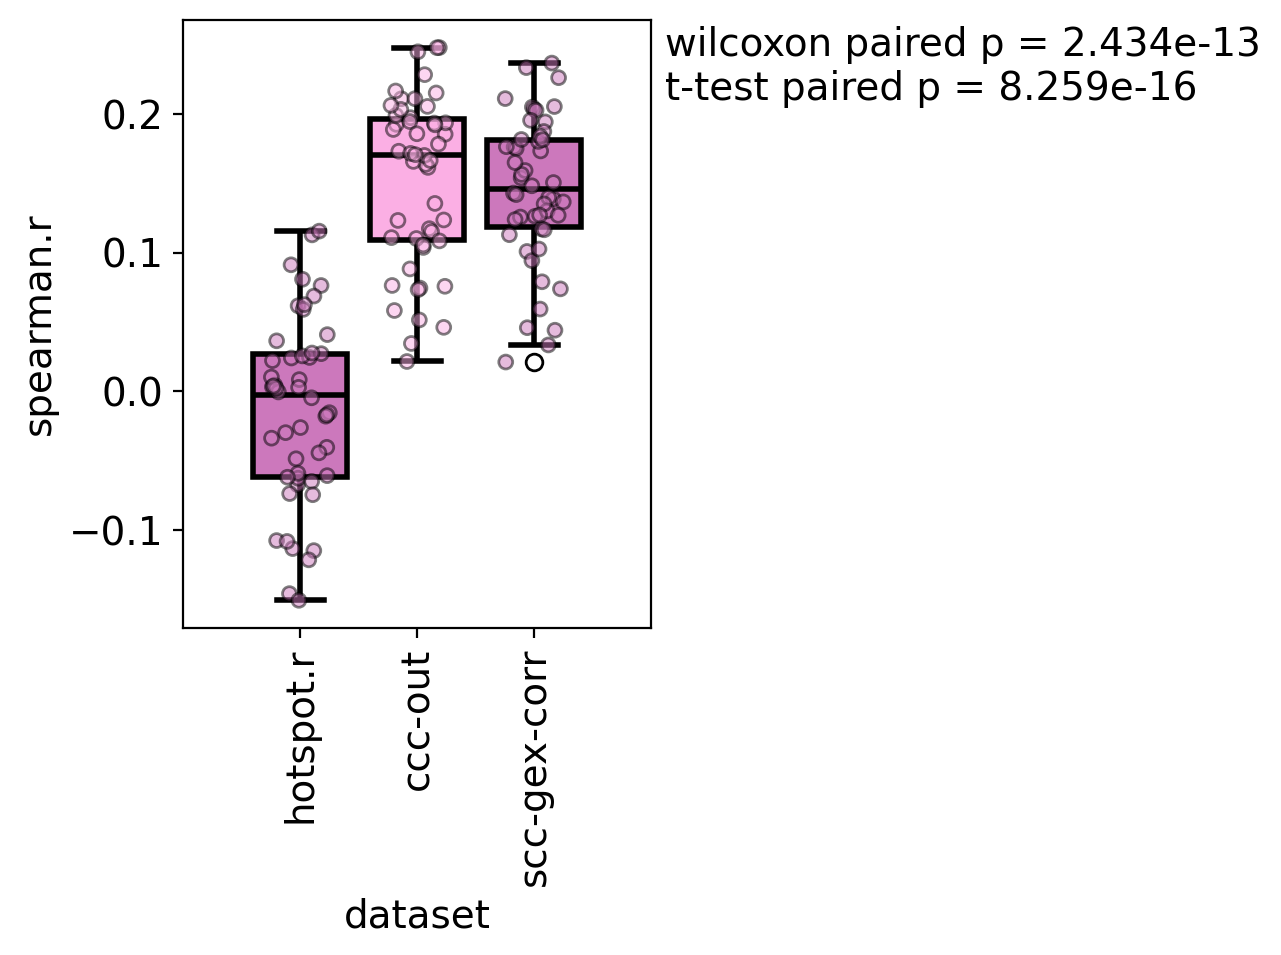

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# run through all of the plots
for metric, value, datasets in plotters:
    # plot key pairwise metrics
    fig, ax = plt.subplots(figsize=[3, 4])
    ax.grid(False)
    ax = sns.boxplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=0,
                     saturation=1, ax=ax, order=datasets, linecolor='k', linewidth=2, palette=['#cc78bc','#fbafe4'])
    ax = sns.stripplot(x='dataset', y=value, data=data.loc[data['metric'] == metric], zorder=2,
                       ax=ax, order=datasets, edgecolor='k', linewidth=1, jitter=0.25, alpha=0.5, palette=['#cc78bc','#fbafe4'])
    ax.tick_params(axis='x', labelrotation=90)
    if value == 'nlog10p1en4_value':
        ax.set_ylabel(f'-log10({metric}+1e-4)')
    else:
        ax.set_ylabel(f'{metric}')
    # derive the values
    x1 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[0]), value].reset_index().iloc[:, 1]
    x2 = data.loc[(data['metric'] == metric)&(data['dataset'] == datasets[1]), value].reset_index().iloc[:, 1]
    mask = (~x1.isna()) & (~x2.isna())
    x1, x2 = x1.loc[mask], x2.loc[mask]
    # for idx in x1.index:
    #     ax.plot(datasets, [x1.loc[idx], x2.loc[idx]], color='k', lw=0.5, alpha=0.5, zorder=1)
    # derive the p-value
    pval1 = ss.wilcoxon(x1, x2)[1]
    pval2 = ss.ttest_rel(x1, x2)[1]
    text = 'wilcoxon paired p = %.3e' % pval1
    text += '\nt-test paired p = %.3e' % pval2
    ax.text(1.03, .99, text, va='top', ha='left', transform=ax.transAxes)
    ax.set_xlim(-1, 3)